<img src="https://support.appsflyer.com/hc/article_attachments/360001968989/twitter_logo.jpg" style='float:right; width:200px; margin: 0 20px;'>

# Twitter Stance Classification
---

> Simple example of running the MAXCUT algorithem for `stance classification` in Twitter conversations


In [1]:
# env 
import sys
sys.path.append('/Users/shaimeital/code/thesis/cmv-stance-classification')
sys.path.append('/Users/shaimeital/code/thesis/conversant')

In [2]:
from collections import Counter
from itertools import combinations
from typing import Sequence, Tuple, Iterable
import numpy as np
import tqdm
import pandas as pd
from stance_classification.reddit_conversation_parser import CMVConversationReader
from stance_classification.utils import iter_trees_from_lines
from conversant.conversation.parse import ConversationParser
from conversant.conversation import NodeData
import networkx as nx

## Load conversation data
We load conversation data in jsonL format using the `Conversant` package 

In [38]:
conv_id = "1274782757907030016"
sample= pd.read_json(f'/Users/shaimeital/code/thesis/cmv-stance-classification/data/Twitter Conversation/conv-{conv_id}/tweets.jsonl',
                     lines= True,
                     dtype={'in_reply_to_status_id_str':str, 'conversation_id_str': str, 'text':str, 'id_str':'str'})
sample.head()

,created_at,id_str,text,truncated,entities,source,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,user_id_str,retweet_count,favorite_count,conversation_id_str,lang,is_quote_status,quoted_status_id_str,possibly_sensitive_editable,self_thread,place,extended_entities
0,2020-06-21 21:28:47+00:00,1274816558519418880,"@ylecun Yann, here's a fun experiment: trainin...",1.0,"{'user_mentions': [{'screen_name': 'ylecun', '...","<a href=""http://twitter.com/#!/download/ipad"" ...",1274782757907030016,48008938.0,ylecun,39547749,6,61,1274782757907030016,en,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-21 19:47:51+00:00,1274791158913302529,@RandomlyWalking Because people should be awar...,NaN,{'user_mentions': [{'screen_name': 'RandomlyWa...,"<a href=""http://twitter.com/download/android"" ...",1274783738929405952,21815759.0,RandomlyWalking,48008938,0,128,1274782757907030016,en,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-06-20 16:36:36+00:00,1274380641644294150,This image speaks volumes about the dangers of...,NaN,"{'urls': [{'url': 'https://t.co/GsoQqSr3XP', '...","<a href=""https://mobile.twitter.com"" rel=""nofo...",nan,NaN,NaN,2393183286,618,1942,1274380641644294150,en,1.0,1.274315e+18,1.0,{'id_str': '1274380641644294150'},NaN,NaN
3,2020-06-21 21:09:35+00:00,1274811728296017928,@ylecun Train it on the *WHOLE* American popul...,1.0,"{'user_mentions': [{'screen_name': 'ylecun', '...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1274782757907030016,48008938.0,ylecun,144553035,49,326,1274782757907030016,en,1.0,1.204053e+18,1.0,NaN,NaN,NaN
4,2020-06-21 19:14:28+00:00,1274782757907030016,ML systems are biased when data is biased.\nTh...,1.0,"{'urls': [{'url': 'https://t.co/O7IBsrUB1b', '...","<a href=""http://twitter.com/download/android"" ...",nan,NaN,NaN,48008938,515,2733,1274782757907030016,en,1.0,1.274381e+18,1.0,NaN,NaN,NaN


In [4]:
cols = ['created_at', 'id_str', 'text', 'user_id_str', 'conversation_id_str', 'in_reply_to_status_id_str', 'in_reply_to_screen_name']

In [5]:
sample = sample.filter(cols)
sample.head()

,created_at,id_str,text,user_id_str,conversation_id_str,in_reply_to_status_id_str,in_reply_to_screen_name
0,2020-06-21 21:28:47+00:00,1274816558519418880,"@ylecun Yann, here's a fun experiment: trainin...",39547749,1274782757907030016,1274782757907030016,ylecun
1,2020-06-21 19:47:51+00:00,1274791158913302529,@RandomlyWalking Because people should be awar...,48008938,1274782757907030016,1274783738929405952,RandomlyWalking
2,2020-06-20 16:36:36+00:00,1274380641644294150,This image speaks volumes about the dangers of...,2393183286,1274380641644294150,nan,NaN
3,2020-06-21 21:09:35+00:00,1274811728296017928,@ylecun Train it on the *WHOLE* American popul...,144553035,1274782757907030016,1274782757907030016,ylecun
4,2020-06-21 19:14:28+00:00,1274782757907030016,ML systems are biased when data is biased.\nTh...,48008938,1274782757907030016,nan,NaN


Make sure we have only one conversation in our data

In [8]:
assert sample.conversation_id_str.nunique() == 1, 'data have more then one conversation'

In [7]:
# quick fix - more then 1 conversation id
print(sample.count().values[0])
sample = sample.loc[sample.conversation_id_str == conv_id]
print(sample.count().values[0])

264
255


In [9]:
assert sample.loc[sample.in_reply_to_status_id_str == 'nan'].count().values[0] == 1, \
                                                      'more then one root found in conversation'

In [10]:
# quick fix - more then 1 root
print(sample.count().values[0])
sample = sample.loc[sample.id_str != '1203416002626805765']
print(sample.count().values[0])


255
255


In [11]:
assert len(set(sample.in_reply_to_status_id_str).difference(set(sample.id_str))) > 1, 'Some parents are not in the id list'

In [12]:
sample.head()

,created_at,id_str,text,user_id_str,conversation_id_str,in_reply_to_status_id_str,in_reply_to_screen_name
0,2020-06-21 21:28:47+00:00,1274816558519418880,"@ylecun Yann, here's a fun experiment: trainin...",39547749,1274782757907030016,1274782757907030016,ylecun
1,2020-06-21 19:47:51+00:00,1274791158913302529,@RandomlyWalking Because people should be awar...,48008938,1274782757907030016,1274783738929405952,RandomlyWalking
3,2020-06-21 21:09:35+00:00,1274811728296017928,@ylecun Train it on the *WHOLE* American popul...,144553035,1274782757907030016,1274782757907030016,ylecun
4,2020-06-21 19:14:28+00:00,1274782757907030016,ML systems are biased when data is biased.\nTh...,48008938,1274782757907030016,nan,NaN
5,2020-06-21 19:46:20+00:00,1274790777516961792,@ArcusCoTangens Not so much ML researchers but...,48008938,1274782757907030016,1274784988983169025,ArcusCoTangens


In [18]:
important_id = 1274816558519418880

Single conversation parsing

In [13]:
class Twitterconversationreader(ConversationParser[pd.DataFrame, pd.Series]):

    def __init__(self):
        super().__init__()


    def extract_node_data(self, raw_node: pd.Series, verbose =0) -> NodeData:
        node_id = raw_node.id_str
        if verbose > 0:
            print(f'parsing node id {node_id}')
        author = raw_node.user_id_str
        timestamp = raw_node.created_at
        data = dict(raw_node)
        parent_id = data.get('in_reply_to_status_id_str')
        if parent_id == 'nan':
            parent_id = None
            print(f'root node is {node_id}')
            
        return NodeData(node_id, author, timestamp, data, parent_id)
        
    def iter_raw_nodes(self, raw_conversation: pd.DataFrame) -> Iterable[pd.Series]:
        for x in raw_conversation.iterrows():
            yield x[1]

In [14]:
twitter_reader = Twitterconversationreader()

In [15]:
conversation = twitter_reader.parse(sample)

root node is 1274782757907030016


In [16]:
len(conversation.participants)

152

In [17]:
len(list(conversation.iter_conversation()))

247

In [24]:
subtree = [node for node in conversation.root.children if node.node_id == str(important_id)][0]
print(repr(subtree))

In [31]:
from conversant.conversation.conversation import Conversation
sub_conv = Conversation(subtree)
sub_conv.size

10

## Create interaction graph from conversation object

In [35]:
from conversant.interactions.reply_interactions_parser import get_reply_interactions_parser

reply_interactions_parser = get_reply_interactions_parser()

interaction_graph = reply_interactions_parser.parse(sub_conv)


In [33]:
interaction_graph.get_core_interactions(inplace=True)

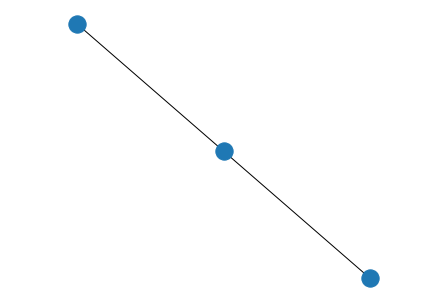

In [36]:
layout = nx.spring_layout(interaction_graph.graph)
nx.draw(interaction_graph.graph, layout)

In [37]:
interaction_graph.graph.nodes

NodeView((48008938, 39547749, 789980646))


## Apply MAXCUT algo for stance classification in the conversation

In [ ]:
interaction_graph.set_interaction_weights(lambda x: x['replies'])

In [ ]:
from stance_classification.classifiers.maxcut_stance_classifier import MaxcutStanceClassifier

In [ ]:
maxcut = MaxcutStanceClassifier()

In [ ]:
maxcut.set_input(interaction_graph.graph)

In [ ]:
op = conversation.root.author

In [ ]:
maxcut.classify_stance(op)

In [ ]:
maxcut.draw()